# Исследование тарифных планов оператора сотовой связи

## Предмет исследования

Данные о звонках, СМС и использовании мобильного интернета выборки из 500 пользователей за 2018 год.

## Тарифные планы

<table>
    <thead>
        <th>Тариф</th>
        <th>Ежемесячная плата</th>
        <th>Включено<br>минут разговора</th>
        <th>Включено<br>сообщений</th>
        <th>Включено<br>Гб интернет-трафика</th>
        <th>Дополнительная<br>минута разговора</th>
        <th>Дополнительное<br>сообщение</th>
        <th>Дополнительный<br>1 Гб интернет-трафика</th>
    </thead>
    <tbody>
        <tr>
            <td>Smart</td>
            <td>550 руб.</td>
            <td>500</td>
            <td>50</td>
            <td>15</td>
            <td>3 руб.</td>
            <td>3 руб.</td>
            <td>200 руб.</td>
        </tr>
        <tr>
            <td>Ultra</td>
            <td>1950 руб.</td>
            <td>3000</td>
            <td>1000</td>
            <td>30</td>
            <td>1 руб.</td>
            <td>1 руб.</td>
            <td>150 руб.</td>
        </tr>
    </tbody>
</table>


## Цели исследования

* Выяснить какой тариф в среднем приносит больше выручки с одного клиента;
* Выявить отличия в поведении пользователей из Москвы и других населенных пунктах;

# Импорты

In [1]:
import pandas as pd
import numpy as np
import math as m

from scipy import stats as st
from IPython.display import clear_output

import functions as func # local file

In [2]:
PLOT_TYPE_TARIFF = 'tariff_type'
PLOT_TYPE_LOCATION = 'location_type'

# Сбор и предобработка данных

Данные разбиты на 5 таблиц. Будем рассматривать их по порядку и производить предобработку.<br>Затем объединим таблицы в финальный DataFrame, который будем анализировать.

### Таблица users (информация о пользователях):
* **user_id** — уникальный идентификатор пользователя;
* **first_name** — имя пользователя;
* **last_name** — фамилия пользователя;
* **age** — возраст пользователя (годы);
* **reg_date** — дата подключения тарифа (день, месяц, год);
* **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* **city** — город проживания пользователя;
* **tariff** — название тарифного плана;

In [3]:
users_source_df = pd.read_csv('data/users.csv')
display(users_source_df.head(10))
display(users_source_df.dtypes)

,Unnamed: 0,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Unnamed: 0     int64
user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        object
dtype: object

Для анализа нам не нужны столбцы, `first_name` и `last_name`.<br>
Создадим копию датафрейма без лишних столбцов, которую будем использовать для анализа.

В копии датафрейма приведем данные к нужным типам.

В столбце `city` значения "Москва" оставим без изменений, а остальные заменим на "Другое", так как для анализа нам потребуется именно такое разделение.

Столбец `churn_date` содержит пропуски. Для вычисления длительности использования тарифа на момент выгрузки данных заменим отсутствующие значения на '2019-01-01'.<br>

Нам необходимо исследовать поведение пользователей при использовании определенного тарифа. В такой маленькой выборке данные за неполный месяц (если пользователь подключился или отключился в середине месяца) могут исказить наше представление о реальном поведении пользователей при долгосрочном использовании тарифа.

Чтобы избежать описанных выше искажений значения столбца `reg_date` округлим вверх до 1 числа следующего месяца, значения столбца `churn_date` окнуглим вниз до последнего числа предыдущего месяца.

In [4]:
users_df = users_source_df[['user_id', 'age', 'city', 'tariff', 'reg_date', 'churn_date']].copy()

def update_user_city(city):
    if city != 'Москва': city = 'Другое'
    return city

users_df['city'] = users_df['city'].apply(update_user_city)

users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'].fillna('2018-12-31'), format='%Y-%m-%d')

users_df['reg_date'] = users_df['reg_date'] - pd.DateOffset(1) + pd.offsets.MonthBegin(1)
users_df['churn_date'] = users_df['churn_date'] + pd.DateOffset(1) + pd.offsets.MonthEnd(-1)

Добавим столбец содержащий количество месяцев использования тарифного плана.

In [5]:
users_df['time_delta'] = (users_df['churn_date'] - users_df['reg_date']) / np.timedelta64(1,'M')
users_df['time_delta'] = users_df['time_delta'].round().astype(int)

print(
    'Доля пользователей использующих тариф меньше месяца: {:.2%}'
    .format(len(users_df.query('time_delta < 1'))/len(users_df))
)

Доля пользователей использующих тариф меньше месяца: 8.00%


Удалим клиентов, которые использовали тариф менее месяца.

In [6]:
users_df = users_df.drop(users_df.query('time_delta < 1').index)
len(users_df)

460

Сохраним значение количества уникальных пользователей для дальнейшей работы:

In [7]:
UNIQUE_USERS_COUNT = len(users_df)

При работе с оставшимися датафреймами необходимо будет учитывать, что у нас изменилось количество пользователей и рассматриваемые периоды их активности.

Напишем функцию для отчистки датафреймов от лишних строк:

In [8]:
def clear_unnecessary_rows(_df, datecol_name):
    _df = _df.copy()
    source_len = len(_df)
    
    user_id_values = users_df['user_id'].values
    
    _df = _df[_df['user_id'].isin(user_id_values)]
    
    for user_id in user_id_values:
        user_reg_date = users_df.query('user_id == @user_id')['reg_date'].values[0]
        user_churn_date = users_df.query('user_id == @user_id')['churn_date'].values[0]
        
        user_id_condition = _df['user_id'] == user_id
        reg_date_condition = _df[datecol_name] < user_reg_date
        churn_date_condition = _df[datecol_name] > user_churn_date
        
        bad_data_indexes = _df[user_id_condition & (reg_date_condition | churn_date_condition)].index
        
        _df = _df.drop(bad_data_indexes)
    
    final_len = len(_df)
    
    print('Удалено {:.1%} данных.'.format(1 - final_len/source_len))
    
    return _df

### Таблица tariffs (информация о тарифах):
* **tariff_name** — название тарифа;
* **rub_monthly_fee** — ежемесячная абонентская плата в рублях;
* **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату;
* **messages_included** — количество сообщений в месяц, включённых в абонентскую плату;
* **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета<br>(например, если в тарифе 100 минут разговора в месяц, то со 101 * минуты будет взиматься плата);
* **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета;
* **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта);

In [9]:
tariffs_df = pd.read_csv('data/tariffs.csv')
tariffs_df

,Unnamed: 0,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,0,50,15360,500,550,200,3,3,smart
1,1,1000,30720,3000,1950,150,1,1,ultra


### Таблица calls (информация о звонках):
* **id** — уникальный номер звонка;
* **call_date** — дата звонка;
* **duration** — длительность звонка в минутах;
* **user_id** — идентификатор пользователя, сделавшего звонок;

In [10]:
calls_source_df = pd.read_csv('data/calls.csv')
display(calls_source_df.head())
display('Типы данных:')
display(calls_source_df.dtypes)
display('Пропущенные значения:')
display(calls_source_df.isna().sum())

,Unnamed: 0,id,call_date,duration,user_id
0,0,1000_0,2018-07-25,0.00,1000
1,1,1000_1,2018-08-17,0.00,1000
2,2,1000_2,2018-06-11,2.85,1000
3,3,1000_3,2018-09-21,13.80,1000
4,4,1000_4,2018-12-15,5.18,1000


'Типы данных:'

Unnamed: 0      int64
id             object
call_date      object
duration      float64
user_id         int64
dtype: object

'Пропущенные значения:'

Unnamed: 0    0
id            0
call_date     0
duration      0
user_id       0
dtype: int64

Приведем данные столбца `call_date` к типу данных `datetime`.

In [11]:
calls_df = calls_source_df.copy()
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')
display(calls_df.dtypes)

Unnamed: 0             int64
id                    object
call_date     datetime64[ns]
duration             float64
user_id                int64
dtype: object

Удалим лишние строки (пользователей, которых мы не рассматриваем и события не входящие в рассматриваемый период времени).

In [12]:
calls_df = clear_unnecessary_rows(calls_df, 'call_date')

Удалено 8.8% данных.


Учитывая, что оператор сотовой связи всегда округляет вверх значения минут и мегабайтов (если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута), округлим все значения столбца `duration` вверх.

In [13]:
calls_df['duration'] = np.ceil(calls_df['duration'])

В столбце `duration` присутствуют нулевые значения. Посмотрим на долю нулевых значений:

In [14]:
print('{:.1%}'.format(len(calls_df.query('duration == 0'))/len(calls_df)))

19.6%


Почти каждый 5 звонок в нашей выборке имеет длительность 0.0 минут.<br>
Это повод обратиться к разработчикам и выяснить причины появления подобных значений и способ их интерпретации, но так как в данный момент такой возможности нет - попробуем выявить закономерность в звонках с нулевой длительностью и самостоятельно понять, как можно интерпретировать данные значения.

Посмотрим долю пользователей у которых присутствуют нулевые значения длительности звонка:

In [15]:
print(
    'Доля пользователей с нулевыми значениями длительности звонка составляет {:.1%}'
    .format(len(calls_df.query('duration == 0')['user_id'].unique()) / UNIQUE_USERS_COUNT)
)

Доля пользователей с нулевыми значениями длительности звонка составляет 98.7%


Подобные значения встречаются почти у всех пользователей из выборки.

Рассмотрим распределение нулевых значений длительности звонка по месяцам:

In [16]:
calls_df['call_month'] = calls_df['call_date'].dt.month
call_month_value_counts = calls_df['call_month'].value_counts()
call_month_value_counts

12    31275
11    27744
10    25205
9     22934
8     19878
7     16673
6     13741
5     11541
4      7700
3      5383
2      2533
1       181
Name: call_month, dtype: int64

Общее количество звонков в нашей выборке растет с каждым месяцем, так как в первый месяц совершают звонки только пользователи зарегистрировавшиеся в первый месяц, во второй месяц звонки совершают пользователи зарегистрировавшиеся в первый и второй месяц и так далее.

Сложно будет оценить распределение нулевых значений используя только их количество в определенный месяц, поэтому рассмотрим долю звонков с нулевой длительностью по каждому месяцу.

Для удобства и возможности переиспользовать код напишем функцию возвращающую датафрейм с долями звонков с нулевой длительностью для разных срезов данных:

In [17]:
def zero_duration_part_df(_df, param_column_name, zero_column_name='duration'):
    return pd.DataFrame(
        {
                'Zero duration part': 
                (
                    _df[_df[zero_column_name] == 0][param_column_name].value_counts() / 
                    _df[param_column_name].value_counts()
                )
            }
        ).style.format({'Zero duration part': '{:,.1%}'.format})

In [18]:
zero_duration_part_df(calls_df, 'call_month')

,Zero duration part
12,19.5%
11,19.8%
10,19.8%
9,19.2%
8,19.7%
7,19.3%
6,19.7%
5,20.0%
4,19.1%
3,19.4%


Доля звонков с нулевой длительностью практически не меняется с течением времени.

Для дальнейшего анализа нам понадобятся более подробные данные о пользователе. Создадим временный датафрейм, в котором объединим таблицы `calls_df` и `users_df` и продолжим анализ:

In [19]:
calls_and_users_df = calls_df.merge(users_df, on='user_id', how='left')
calls_and_users_df.head()

,Unnamed: 0,id,call_date,duration,user_id,call_month,age,city,tariff,reg_date,churn_date,time_delta
0,0,1000_0,2018-07-25,0.0,1000,7,52,Другое,ultra,2018-06-01,2018-12-31,7
1,1,1000_1,2018-08-17,0.0,1000,8,52,Другое,ultra,2018-06-01,2018-12-31,7
2,2,1000_2,2018-06-11,3.0,1000,6,52,Другое,ultra,2018-06-01,2018-12-31,7
3,3,1000_3,2018-09-21,14.0,1000,9,52,Другое,ultra,2018-06-01,2018-12-31,7
4,4,1000_4,2018-12-15,6.0,1000,12,52,Другое,ultra,2018-06-01,2018-12-31,7


Рассмотрим долю звонков с нулевой длительностью для разных тарифов:

In [20]:
zero_duration_part_df(calls_and_users_df, 'tariff')

,Zero duration part
smart,19.7%
ultra,19.3%


Доли звонков c нулевой длительностью практически одинаковые для обоих тарифов.

Рассмотрим долю звонков c нулевой длительностью для разных возростных групп:

In [21]:
calls_and_users_df['age_cut'] = pd.cut(calls_and_users_df['age'], 19)
zero_duration_part_df(calls_and_users_df, 'age_cut')

,Zero duration part
"(17.943, 21.0]",18.9%
"(21.0, 24.0]",19.2%
"(24.0, 27.0]",19.5%
"(27.0, 30.0]",19.3%
"(30.0, 33.0]",19.7%
"(33.0, 36.0]",20.7%
"(36.0, 39.0]",19.0%
"(39.0, 42.0]",19.9%
"(42.0, 45.0]",20.0%
"(45.0, 48.0]",20.1%


Зависимости между возрастной группой и количеством звонков c нулевой длительностью не обнаружено.

Рассмотрим долю звонков c нулевой длительностью для разных населенных пунктов:

In [22]:
zero_duration_part_df(calls_and_users_df, 'city')

,Zero duration part
Другое,19.6%
Москва,19.3%


Зависимости между населенным пунктом и количеством звонков c нулевой длительностью также не наблюдается.

Выявить закономерноть в появлении звонков с нулевой длительностью на основании имеющихся у нас параметров не удалось.

Теперь необходимо решить, каким образом мы интерпретируем нулевые значения.

Предположим, что нулевые значения появляются, когда пользователь звонит по телефону, но не дождавшись ответа кладет трубку.<br>
В таком случае в нашей выборке должно быть достаточно много нулевых значений идущих подряд друг за другом (пользователь пытается до кого-то дозвониться).<br>
Для более точной проверки данной гипотезы потребуются данные о точном времени звонков и номера телефонов на которые звонили. Если будет много звонков с нулевой длительностью на одни и те же номера за короткий промежуток времени - это будет свидетельствовать о состоятельности выдвинутой гипотезы.<br>
Так как такой возможности в данный момент нет - посмотрим количество идущих подряд нулевых значений (в один день и у одного пользователя для каждой пары повторений).

In [23]:
# Код ниже отрабатывает, примерно, за 15 минут. 
# Результаты работы скрипта продублированы в маркдаун ячейках.


# zero_sequences = []

# i = 0
# calls_and_users_df_len = len(calls_and_users_df)
    

# for user_id in calls_and_users_df['user_id'].unique():
    
#     one_user_data = calls_and_users_df.query('user_id == @user_id')
    
#     for call_date in one_user_data['call_date'].unique():
#         one_user_one_date_data = one_user_data.query('call_date == @call_date')
        
#         zero_rows_count = 0
        
#         for duration in one_user_one_date_data['duration']:
#             i += 1
#             clear_output(wait=True)
#             print('Progress: {:.2%} ({} from {})'.format(i/calls_and_users_df_len, i, calls_and_users_df_len))
            
#             if duration == 0:
#                 zero_rows_count += 1
#             else:
#                 if zero_rows_count > 1:
#                     zero_sequences.append(zero_rows_count)
#                 zero_rows_count = 0
                
# print('zero_sequences len:', len(zero_sequences))

Мы получили массив из 2056 последовательностей идущих подряд звонков с нулевой длительностью.

Посмотрим какая доля звонков с нулевой длительностью идут подряд друг за другом:

In [24]:
# zero_sequences_series = pd.Series(zero_sequences)
# zero_sequences_part = zero_sequences_series.sum() / calls_and_users_df.query('duration == 0')['duration'].count()

# print('Доля звонков входящих в последовательности: {:.1%}'.format(zero_sequences_part))

Примерно каждый 10 (12.1%) звонок с нулевой длительностью находится в последовательности идущих друг за другом звонков.

Принимая во внимание, что:

1. Не всегда пользователи пробуют перезвонить, если не дозвонились с первого раза;
2. Во вторую попытку пользователь мог дозвониться до собеседника;
3. Причинами возможных звонков без ответа могут также: случайно набранный в кармане (неверный) номер, звонок на номер телефона вне зоны действия сети, звонок на неверный номер (ошибка при наборе) и т.д. Данные причины не подразумевают повторный набор номера;

**Последующий анализ будем осуществлять интерпретируя нулевые значения как звонки без ответа.**

### Таблица messages (информация о сообщениях):
* **id** — уникальный номер сообщения;
* **message_date** — дата сообщения;
* **user_id** — идентификатор пользователя, отправившего сообщение;

In [25]:
messages_source_df = pd.read_csv('data/messages.csv')

display(messages_source_df.head())
display('Типы данных:')
display(messages_source_df.dtypes)
display('Пропущенные значения:')
display(messages_source_df.isna().sum())

,Unnamed: 0,id,message_date,user_id
0,0,1000_0,2018-06-27,1000
1,1,1000_1,2018-10-08,1000
2,2,1000_2,2018-08-04,1000
3,3,1000_3,2018-06-16,1000
4,4,1000_4,2018-12-05,1000


'Типы данных:'

Unnamed: 0       int64
id              object
message_date    object
user_id          int64
dtype: object

'Пропущенные значения:'

Unnamed: 0      0
id              0
message_date    0
user_id         0
dtype: int64

Приведем данные столюбца `message_date` к типу данных `datetime`.

In [26]:
messages_df = messages_source_df.copy()
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')
display(messages_df.dtypes)

Unnamed: 0               int64
id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

Удалим лишние строки (пользователей, которых мы не рассматриваем и события не входящие в рассматриваемый период времени).

In [27]:
messages_df = clear_unnecessary_rows(messages_df, 'message_date')

Удалено 9.2% данных.


Таблица с информацией о сообщениях готова к работе.

### Таблица internet (информация об интернет-сессиях):
* **id** — уникальный номер сессии;
* **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах);
* **session_date** — дата интернет-сессии;
* **user_id** — идентификатор пользователя;

In [28]:
internet_source_df = pd.read_csv('data/internet.csv')

display(internet_source_df.head())
display('Типы данных:')
display(internet_source_df.dtypes)
display('Пропущенные значения:')
display(internet_source_df.isna().sum())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


'Типы данных:'

Unnamed: 0        int64
id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object

'Пропущенные значения:'

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Приведем данные столбца `session_date` к типу данных `datetime`.

In [29]:
internet_df = internet_source_df.copy()
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')
display(internet_df.dtypes)

Unnamed: 0               int64
id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

Удалим лишние строки (пользователей, которых мы не рассматриваем и события не входящие в рассматриваемый период времени).

In [30]:
internet_df = clear_unnecessary_rows(internet_df, 'session_date')

Удалено 9.1% данных.


Округлим значения столбца `mb_used` вверх.

In [31]:
internet_df['mb_used'] = np.ceil(internet_df['mb_used'])

Проверим наличие нулевых значений в столбце `mb_used`.

In [32]:
print('Доля нулевых значений: {:.1%}'.format(len(internet_df.query('mb_used == 0')) / len(internet_df)))

Доля нулевых значений: 13.1%


Как и в таблице с данными о звонках, в таблице с данными об интернет сессиях присутствуют нулевые значения.<br>
Но, в отличии от звонков, мы не можем их логично интерпретировать, так как само открытие сессии подразумевает передачу данных.

Попробуем найти закономерность в появлении нулевых значений.

In [33]:
print(
    'Доля пользователей с нулевыми значениями длительности звонка составляет {:.1%}'
    .format(len(internet_df.query('mb_used == 0')['user_id'].unique()) / UNIQUE_USERS_COUNT)
)

Доля пользователей с нулевыми значениями длительности звонка составляет 98.7%


Рассмотрим распределение нулевых значений длительности звонка по месяцам:

In [34]:
internet_df['session_month'] = internet_df['session_date'].dt.month
internet_df['session_month'].value_counts()

12    22836
11    20571
10    18547
9     16607
8     14822
7     12437
6     10223
5      8326
4      5375
3      4130
2      1912
1        71
Name: session_month, dtype: int64

Наблюдаем распределение по месяцам как в таблице со звонками.

рассмотрим долю звонков с нулевой длительностью по каждому месяцу.

In [35]:
zero_duration_part_df(internet_df, 'session_month', 'mb_used')

,Zero duration part
12,13.4%
11,13.3%
10,13.3%
9,13.1%
8,12.8%
7,12.8%
6,12.7%
5,12.8%
4,12.3%
3,12.6%


Для дальнейшего анализа нам понадобятся более подробные данные о пользователе. Создадим временный датафрейм, в котором объединим таблицы `internet_df` и `users_df` и продолжим анализ:

In [36]:
internet_and_users_df = internet_df.merge(users_df, on='user_id', how='left')
internet_and_users_df.head()

,Unnamed: 0,id,mb_used,session_date,user_id,session_month,age,city,tariff,reg_date,churn_date,time_delta
0,0,1000_0,113.0,2018-11-25,1000,11,52,Другое,ultra,2018-06-01,2018-12-31,7
1,1,1000_1,1053.0,2018-09-07,1000,9,52,Другое,ultra,2018-06-01,2018-12-31,7
2,2,1000_2,1198.0,2018-06-25,1000,6,52,Другое,ultra,2018-06-01,2018-12-31,7
3,3,1000_3,551.0,2018-08-22,1000,8,52,Другое,ultra,2018-06-01,2018-12-31,7
4,4,1000_4,303.0,2018-09-24,1000,9,52,Другое,ultra,2018-06-01,2018-12-31,7


Рассмотрим долю сессий с нулевым трафиком для разных тарифов:

In [37]:
zero_duration_part_df(internet_and_users_df, 'tariff', 'mb_used')

,Zero duration part
smart,15.9%
ultra,4.7%


Доли сессий с нулевым трафиком у пользователей тарифа smart в 3 раза больше, чем у пользователей с тарифом ultra.<br>
Интересное наблюдение, но без более глубокого анализа и наличия дополнительных данных сделать выводы невозможно.

Рассмотрим долю сессий с нулевым трафиком для разных возрастных групп:

In [38]:
internet_and_users_df['age_cut'] = pd.cut(internet_and_users_df['age'], 19)
zero_duration_part_df(internet_and_users_df, 'age_cut', 'mb_used')

,Zero duration part
"(17.943, 21.0]",13.9%
"(21.0, 24.0]",12.6%
"(24.0, 27.0]",11.9%
"(27.0, 30.0]",12.2%
"(30.0, 33.0]",15.2%
"(33.0, 36.0]",13.1%
"(36.0, 39.0]",13.8%
"(39.0, 42.0]",13.0%
"(42.0, 45.0]",12.0%
"(45.0, 48.0]",15.0%


Зависимости между возрастной группой и количеством сессий с нулевым трафиком не обнаружено.

Рассмотрим долю сессий с нулевым трафиком для разных населенных пунктов:

In [39]:
zero_duration_part_df(internet_and_users_df, 'city', 'mb_used')

,Zero duration part
Другое,13.2%
Москва,12.3%


Зависимости между населенным пунктом и количеством сессий с нулевым трафиком также не наблюдается.

После исследования нулевых значений таблицы с данными по использованию мобильного интернета мы заметили сходство в распределении нулевых значений с таблицей содержащей данные о звонках.<br>
В обоих таблицах нулевые значения не зависят от тарифа, параметров пользователя или даты.<br>
Можно сделать предположение о том, что причина появления нулевых значений в обоих таблицах носят одинаковый характер.

Так как нет возможности обратиться к разработчикам и выяснить причины появления нулевых значений, последующий анализ будем производить исходя из предположения, что нулевые значения не являются ошибкой.

Предобработка исходных таблиц завершена.<br>
Для дальнейшего анализа необходимо соединить исходные таблицы в два датафрейма (один с нулевыми значениями, другой без).

## Объединение таблиц

В получившихся таблицах должна присутствовать следующая информация по каждому пользователю:
* Среднее значение отправленных сообщений в месяц;
* Среднее значение использованных за месяц мегабайт мобильного интернета;
* Среднее значение минут разговора в месяц;

In [40]:
df = users_df.copy()

### Добавляем общее количество сообщений для каждого пользователя

In [41]:
messages_group_by_user_df = messages_df.groupby(by='user_id')['id'].agg(['count'])

df = df.merge(messages_group_by_user_df, on='user_id', how='left')
df = df.rename(columns={'count':'messages_total'})
df['messages_total'] = df['messages_total'].fillna(0)
df.head()

,user_id,age,city,tariff,reg_date,churn_date,time_delta,messages_total
0,1000,52,Другое,ultra,2018-06-01,2018-12-31,7,474.0
1,1001,41,Москва,smart,2018-11-01,2018-12-31,2,0.0
2,1002,59,Другое,smart,2018-07-01,2018-12-31,6,66.0
3,1003,23,Москва,ultra,2018-09-01,2018-12-31,4,343.0
4,1004,68,Другое,ultra,2018-06-01,2018-12-31,7,1097.0


### Добавляем общую длительность звонков для каждого пользователя

In [42]:
calls_group_by_user_df = calls_df.groupby(by='user_id')['duration'].agg(['sum']).fillna(0)

df = df.merge(calls_group_by_user_df, on='user_id', how='left')
df = df.rename(columns={'sum':'calls_duration_total'})
df['calls_duration_total'] = df['calls_duration_total'].fillna(0)
df.head()

,user_id,age,city,tariff,reg_date,churn_date,time_delta,messages_total,calls_duration_total
0,1000,52,Другое,ultra,2018-06-01,2018-12-31,7,474.0,2407.0
1,1001,41,Москва,smart,2018-11-01,2018-12-31,2,0.0,844.0
2,1002,59,Другое,smart,2018-07-01,2018-12-31,6,66.0,1400.0
3,1003,23,Москва,ultra,2018-09-01,2018-12-31,4,343.0,3442.0
4,1004,68,Другое,ultra,2018-06-01,2018-12-31,7,1097.0,952.0


### Добавляем общее количество использованных мегабайт трафика для каждого пользователя

In [43]:
internet_group_by_user_df = internet_df.groupby(by='user_id')['mb_used'].agg(['sum']).fillna(0)

df = df.merge(internet_group_by_user_df, on='user_id', how='left')
df = df.rename(columns={'sum':'mb_used_total'})
df['mb_used_total'] = df['mb_used_total'].fillna(0)
df.head()

,user_id,age,city,tariff,reg_date,churn_date,time_delta,messages_total,calls_duration_total,mb_used_total
0,1000,52,Другое,ultra,2018-06-01,2018-12-31,7,474.0,2407.0,105236.0
1,1001,41,Москва,smart,2018-11-01,2018-12-31,2,0.0,844.0,32505.0
2,1002,59,Другое,smart,2018-07-01,2018-12-31,6,66.0,1400.0,105312.0
3,1003,23,Москва,ultra,2018-09-01,2018-12-31,4,343.0,3442.0,48758.0
4,1004,68,Другое,ultra,2018-06-01,2018-12-31,7,1097.0,952.0,135757.0


Объединение таблиц завершено.

# Вычисление выручки с клиента

Вычислим сколько в среднем денег приносят компании пользователи за месяц.

### Вычислим среднее количество сообщений за месяц для каждого пользователя

In [44]:
df['messages_per_month'] = df['messages_total'] / df['time_delta']
df.head()

,user_id,age,city,tariff,reg_date,churn_date,time_delta,messages_total,calls_duration_total,mb_used_total,messages_per_month
0,1000,52,Другое,ultra,2018-06-01,2018-12-31,7,474.0,2407.0,105236.0,67.714286
1,1001,41,Москва,smart,2018-11-01,2018-12-31,2,0.0,844.0,32505.0,0.000000
2,1002,59,Другое,smart,2018-07-01,2018-12-31,6,66.0,1400.0,105312.0,11.000000
3,1003,23,Москва,ultra,2018-09-01,2018-12-31,4,343.0,3442.0,48758.0,85.750000
4,1004,68,Другое,ultra,2018-06-01,2018-12-31,7,1097.0,952.0,135757.0,156.714286


### Вычислим среднюю  длительность разговоров за месяц для каждого пользователя

In [45]:
df['calls_duration_per_month'] = df['calls_duration_total'] / df['time_delta']
df.head()

,user_id,age,city,tariff,reg_date,churn_date,time_delta,messages_total,calls_duration_total,mb_used_total,messages_per_month,calls_duration_per_month
0,1000,52,Другое,ultra,2018-06-01,2018-12-31,7,474.0,2407.0,105236.0,67.714286,343.857143
1,1001,41,Москва,smart,2018-11-01,2018-12-31,2,0.0,844.0,32505.0,0.000000,422.000000
2,1002,59,Другое,smart,2018-07-01,2018-12-31,6,66.0,1400.0,105312.0,11.000000,233.333333
3,1003,23,Москва,ultra,2018-09-01,2018-12-31,4,343.0,3442.0,48758.0,85.750000,860.500000
4,1004,68,Другое,ultra,2018-06-01,2018-12-31,7,1097.0,952.0,135757.0,156.714286,136.000000


### Вычислим среднее количество использованных мегабайт интернета за месяц для каждого пользователя

In [46]:
df['mb_used_per_month'] = df['mb_used_total'] / df['time_delta']
df.head()

,user_id,age,city,tariff,reg_date,churn_date,time_delta,messages_total,calls_duration_total,mb_used_total,messages_per_month,calls_duration_per_month,mb_used_per_month
0,1000,52,Другое,ultra,2018-06-01,2018-12-31,7,474.0,2407.0,105236.0,67.714286,343.857143,15033.714286
1,1001,41,Москва,smart,2018-11-01,2018-12-31,2,0.0,844.0,32505.0,0.000000,422.000000,16252.500000
2,1002,59,Другое,smart,2018-07-01,2018-12-31,6,66.0,1400.0,105312.0,11.000000,233.333333,17552.000000
3,1003,23,Москва,ultra,2018-09-01,2018-12-31,4,343.0,3442.0,48758.0,85.750000,860.500000,12189.500000
4,1004,68,Другое,ultra,2018-06-01,2018-12-31,7,1097.0,952.0,135757.0,156.714286,136.000000,19393.857143


Для дальнейшего анализа столбцы `age`, `reg_date`, `churn_date`, `time_delta`, `messages_total`, `calls_duration_total` и `mb_used_total` не нужны. Сохраняем на всякий случай копию текущих датафрейма, оставляем в датафрейме только необходимые данные.

In [47]:
old_df = df.copy()
df = df[['user_id', 'city', 'tariff', 'messages_per_month', 'calls_duration_per_month', 'mb_used_per_month']]
df.head()

,user_id,city,tariff,messages_per_month,calls_duration_per_month,mb_used_per_month
0,1000,Другое,ultra,67.714286,343.857143,15033.714286
1,1001,Москва,smart,0.000000,422.000000,16252.500000
2,1002,Другое,smart,11.000000,233.333333,17552.000000
3,1003,Москва,ultra,85.750000,860.500000,12189.500000
4,1004,Другое,ultra,156.714286,136.000000,19393.857143


### Вычисляем среднюю сумму, которую пользователь платит за услуги оператора связи

Функция ниже вычисляет стоимость дополнительных минут, мегабайт, сообщений и складывает их с ценой использования тарифа для каждого пользователя.

In [48]:
def calculate_avg_money_spent(row):
    tariff_name = row['tariff']
    
    fee =                 tariffs_df.query('tariff_name == @tariff_name')['rub_monthly_fee'].values[0]
    
    messages_included =   tariffs_df.query('tariff_name == @tariff_name')['messages_included'].values[0]
    megabytes_included =  tariffs_df.query('tariff_name == @tariff_name')['mg_per_month_included'].values[0]
    minutes_included =    tariffs_df.query('tariff_name == @tariff_name')['minutes_included'].values[0]
    
    message_cost =        tariffs_df.query('tariff_name == @tariff_name')['rub_per_message'].values[0]
    gigabyte_cost =       tariffs_df.query('tariff_name == @tariff_name')['rub_per_gb'].values[0]
    minute_cost =         tariffs_df.query('tariff_name == @tariff_name')['rub_per_minute'].values[0]
    
    user_messages_count = row['messages_per_month']
    user_megabytes_used = row['mb_used_per_month']
    user_calls_duration = row['calls_duration_per_month']
    
    messages_over_included = user_messages_count - messages_included
    messages_over_included_cost = messages_over_included * message_cost if messages_over_included > 0 else 0
        
    megabytes_over_included = user_megabytes_used - megabytes_included
    gigabytes_over_included = m.ceil(megabytes_over_included / 1024)
    gigabytes_over_included_cost = gigabytes_over_included * gigabyte_cost if gigabytes_over_included > 0 else 0
    
    minutes_over_included = user_calls_duration - minutes_included
    minutes_over_included_cost = minutes_over_included * minute_cost if minutes_over_included > 0 else 0
    
    total_cost = fee + messages_over_included_cost + gigabytes_over_included_cost + minutes_over_included_cost
    
    return total_cost

In [49]:
df['avg_money_spent'] = df.apply(calculate_avg_money_spent, axis=1)
df.head()

,user_id,city,tariff,messages_per_month,calls_duration_per_month,mb_used_per_month,avg_money_spent
0,1000,Другое,ultra,67.714286,343.857143,15033.714286,1950.0
1,1001,Москва,smart,0.000000,422.000000,16252.500000,750.0
2,1002,Другое,smart,11.000000,233.333333,17552.000000,1150.0
3,1003,Москва,ultra,85.750000,860.500000,12189.500000,1950.0
4,1004,Другое,ultra,156.714286,136.000000,19393.857143,1950.0


# Анализ данных

## Рассмотрим распределение количества отправляемых в среднем за месяц сообщений:

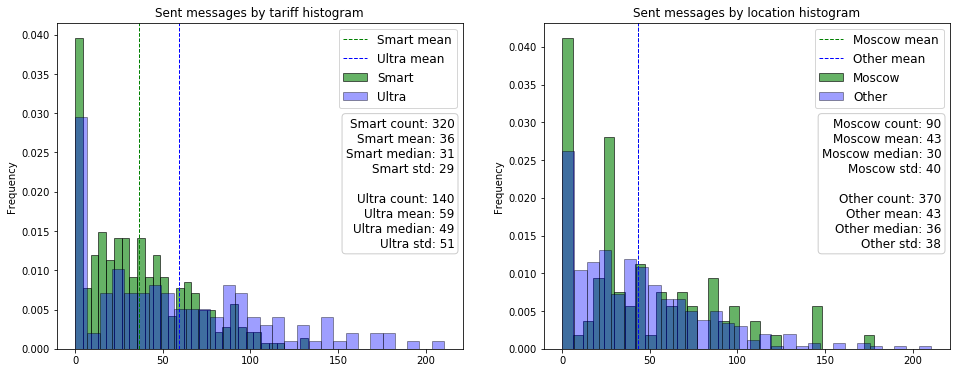

In [50]:
func.show_double_hists(df, 'messages_per_month', 'Sent messages')

### Доля пользователей превышающих лимит сообщений

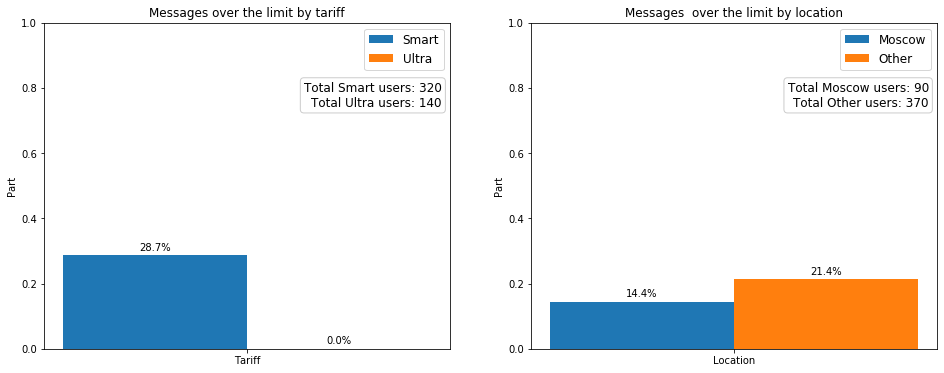

In [51]:
func.show_over_the_limit_bars(df, 'messages_per_month', 50, 1000, 'Messages')

### Вывод:
В среднем, пользователи тарифа Ультра отправляют больше сообщений, чем пользователи тарифа Смарт. Но почти каждый 3 пользователь тарифа Смарт выходит за лимит входящих в стоимость пакета сообщений и доплачивает за них, когда пользователи тарифа Ультра вообще не выходят за лимит входящих в стоимость пакета сообщений.

Пользователи из Москвы и из других городов в среднем отправляют одинаковое количество сообщений, распределения значений очень близки друг к другу по параметрам. Пользователи из других городов выходят за лимит бесплатных сообщений чаще, чем пользователи из Москвы.

## Рассмотрим распределение длительности разговоров в среднем за месяц:

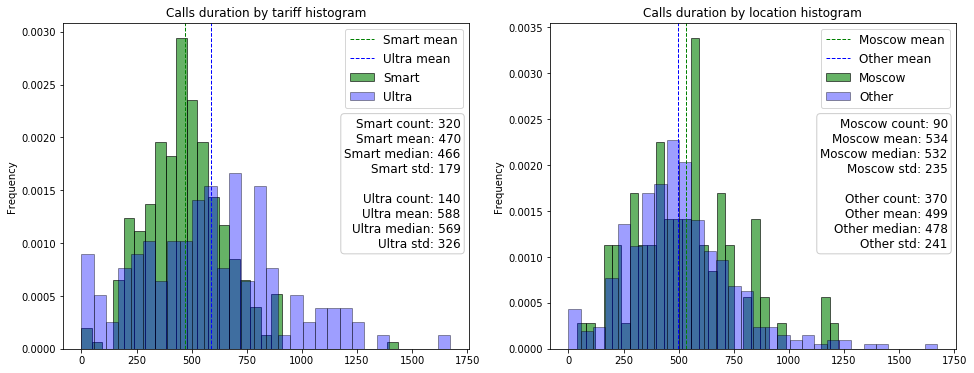

In [52]:
func.show_double_hists(df, 'calls_duration_per_month', 'Сalls duration')

Пользователи тарифа Смарт в среднем разговаривают больше, чем пользователи тарифа Ультра.

Проверим распределения на нормальность.

#### QQPlot графики

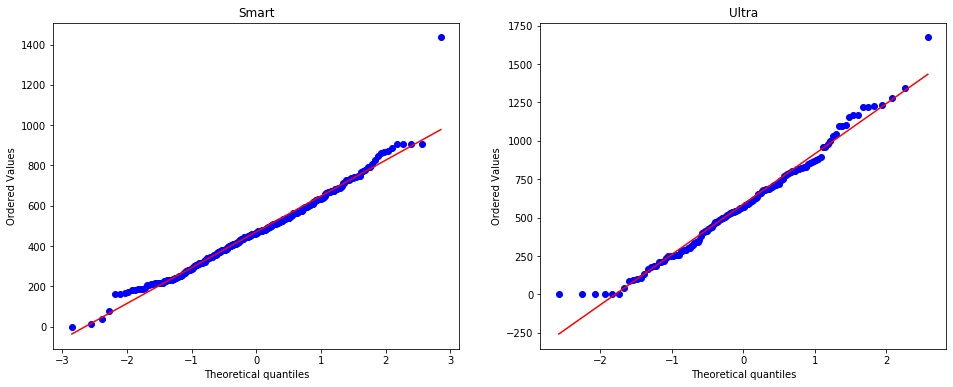

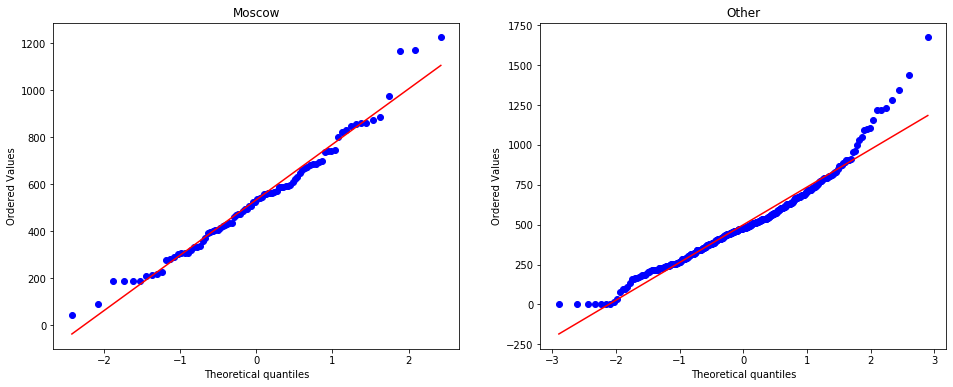

In [53]:
func.qqplots_for_smart_and_ultrs(df, PLOT_TYPE_TARIFF, 'calls_duration_per_month')
func.qqplots_for_smart_and_ultrs(df, PLOT_TYPE_LOCATION, 'calls_duration_per_month')

#### Сравнение распределения по тарифам с теоретическим нормальным

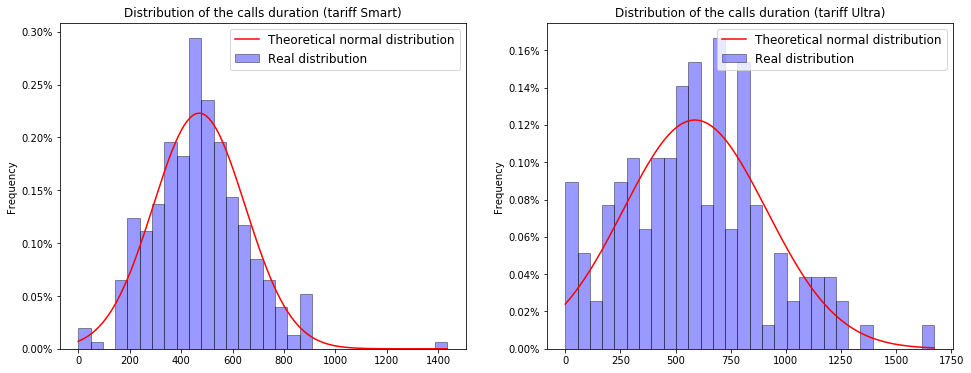

In [54]:
func.show_normal_distribution_over_hist(df, PLOT_TYPE_TARIFF, 'calls_duration_per_month', 'calls duration')

#### Сравнение распределения по городам с теоретическим нормальным

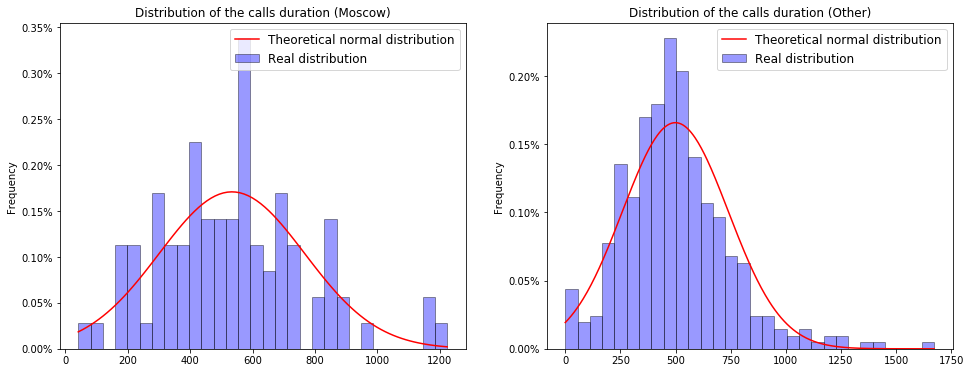

In [55]:
func.show_normal_distribution_over_hist(df, PLOT_TYPE_LOCATION, 'calls_duration_per_month', 'calls duration')

#### Доля пользователей превышающих лимит разговоров

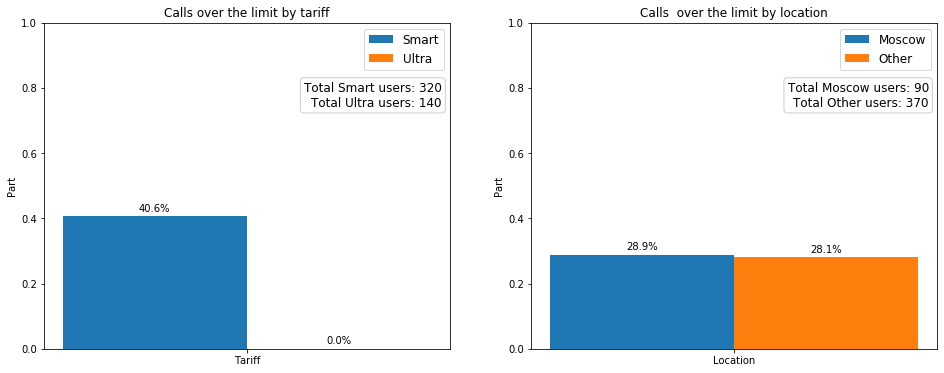

In [56]:
func.show_over_the_limit_bars(df, 'calls_duration_per_month', 500, 3000, 'Calls')

### Вывод
Распределение значений средней длительности звонков за месяц у пользователей тарифа Смарт ближе к нормальному, чем у пользователей тарифа Ультра. Причиной наблюдаемых отличий может быть разный размер выборок (пользователей с тарифом Ультра почти в 3 раза меньше, чем пользователей с тарифом Смарт).

C распределением значений в разных городах наблюдается похожая картина: с увеличением количества наблюдений распределение сильнее стремится к нормальному.

40% пользователей тарифа смарт выходят за лимит бесплатных минут разговоров, когда пользователи тарифа Ультра не выходят за лимит совсем.<br>
В Москве и других городах пользователи выходят за лимит одинаково часто.

## Рассмотрим распределение использованных мегабайт интернета за месяц:

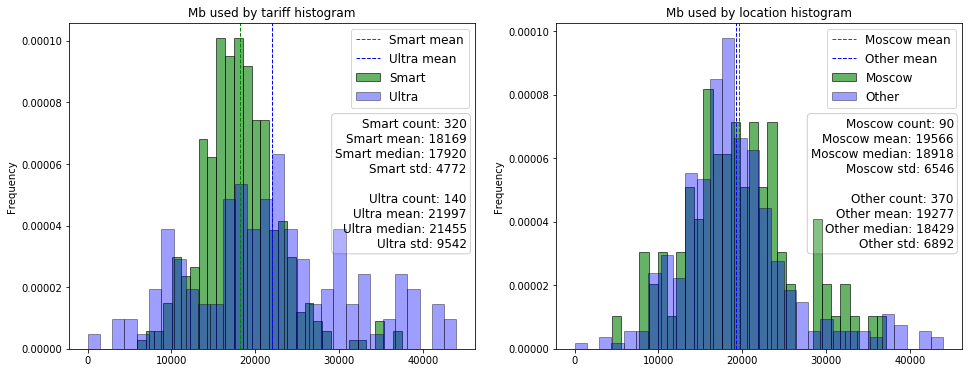

In [57]:
func.show_double_hists(df, 'mb_used_per_month', 'Mb used')

#### QQPlot графики

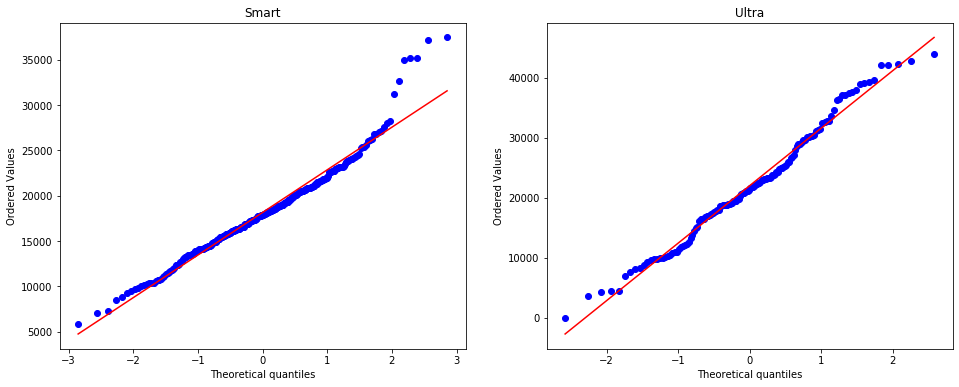

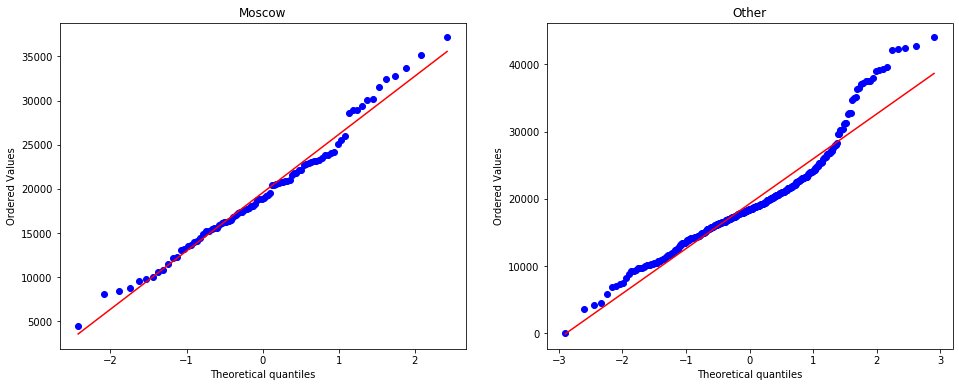

In [58]:
func.qqplots_for_smart_and_ultrs(df, PLOT_TYPE_TARIFF, 'mb_used_per_month')
func.qqplots_for_smart_and_ultrs(df, PLOT_TYPE_LOCATION, 'mb_used_per_month')

Верхние значения у пользователей тарифа Смарт имеют заметное отклонение от нормального распределения. Для пользователей из других регионов наблюдаем похожие отклонения.

#### Сравнение распределения по тарифам с теоретическим нормальным

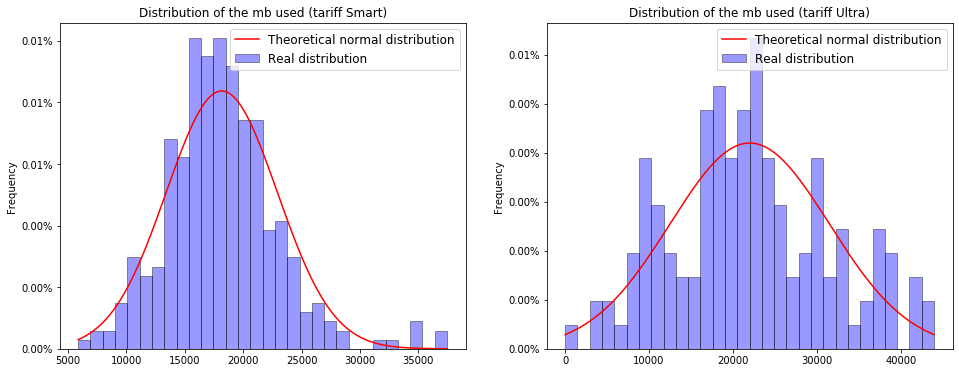

In [59]:
func.show_normal_distribution_over_hist(df, PLOT_TYPE_TARIFF, 'mb_used_per_month', 'mb used')

#### Сравнение распределения по городам с теоретическим нормальным

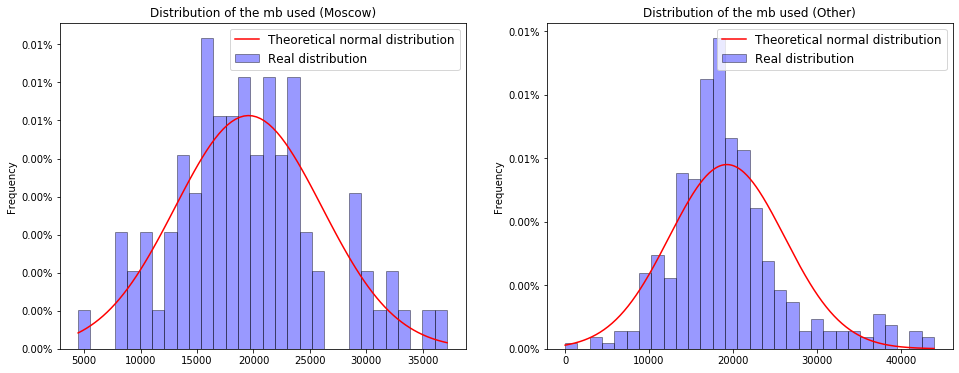

In [60]:
func.show_normal_distribution_over_hist(df, PLOT_TYPE_LOCATION, 'mb_used_per_month', 'mb used')

#### Доля пользователей превышающих лимит входящих в стоимость мегабайт интернета

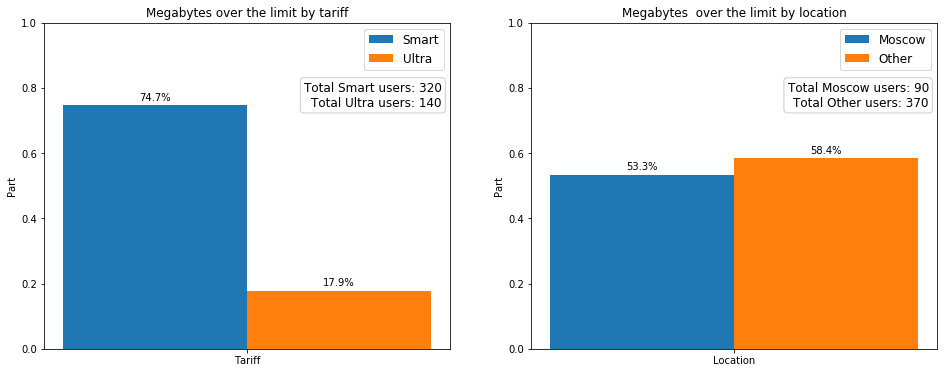

In [61]:
func.show_over_the_limit_bars(df, 'mb_used_per_month', 15*1024, 30*1024, 'Megabytes')

### Вывод
Распределения количества использованных мегабайт интернета стремятся к нормальным, но присутствуют аномальные значения у пользователей тарифа Смарт и пользователей из других городов.

Пользователи обоих тарифов выходят за лимит бесплатных мегабайт интернета, но доля пользователей тарифа Смарт заметно больше.<br>
Долья пользователей выходящих за лимит бесплатных мегабайт интернета из Москвы и других городах почти не отличается.

## Рассмотрим распределение суммы оплаты услуг оператора за месяц:

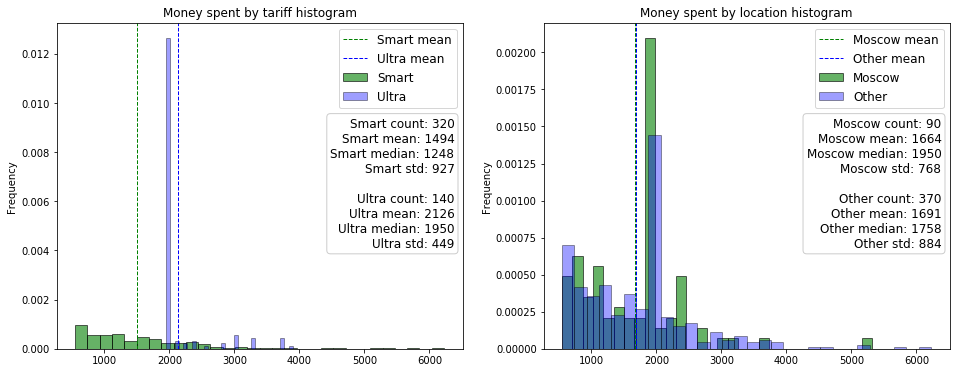

In [62]:
func.show_double_hists(df, 'avg_money_spent', 'Money spent')

На распределениях видны явные пики в районах базовой стоимости тарифов. Наиболее выделяется пик базовой стоимости тарифа Ультра, так как потзователи этого тарифа гораздо реже выходят за лимиты бесплатных минут, мегабайт или смс.

# Проверка гипотез

## Проверим, различается ли выручка с пользователей тарифов Ультра и Смарт

Для дальнейшего анализа нам потребуются только столбцы `user_id`, `city`, `tariff` и `avg_money_spent`.

In [63]:
df = df[['user_id', 'city', 'tariff', 'avg_money_spent']]
df.head()

,user_id,city,tariff,avg_money_spent
0,1000,Другое,ultra,1950.0
1,1001,Москва,smart,750.0
2,1002,Другое,smart,1150.0
3,1003,Москва,ultra,1950.0
4,1004,Другое,ultra,1950.0


In [64]:
ALPHA = 0.05

smart_tariff_data = df.query('tariff == "smart"')['avg_money_spent']
ultra_tariff_data = df.query('tariff == "ultra"')['avg_money_spent']

results = st.ttest_ind(smart_tariff_data, ultra_tariff_data)
print('p-значение: {:.2%}'.format(results.pvalue))
print('Среднее значений пользователей тарифа Смарт: {:.1f}'.format(smart_tariff_data.mean()))
print('Среднее значений пользователей тарифа Ультра: {:.1f}'.format(ultra_tariff_data.mean()))

p-значение: 0.00%
Среднее значений пользователей тарифа Смарт: 1493.8
Среднее значений пользователей тарифа Ультра: 2125.7


### Вывод
P-значение значительно ниже порогового значения.<br>
Выручка с пользователей тарифа Ультра статистически значимо выше, чем с пользователей тарифа Смарт.

## Проверим, различается ли выручка с пользователей из Москвы и из других городов

In [65]:
msk_tariff_data = df.query('city == "Москва"')['avg_money_spent']
other_tariff_data = df.query('city == "Другое"')['avg_money_spent']

results = st.ttest_ind(msk_tariff_data, other_tariff_data)
print('p-значение: {:.2%}'.format(results.pvalue))
print('Среднее значений пользователей из Москвы: {:.1f}'.format(msk_tariff_data.mean()))
print('Среднее значений пользователей из других городов: {:.1f}'.format(other_tariff_data.mean()))

p-значение: 78.60%
Среднее значений пользователей из Москвы: 1663.9
Среднее значений пользователей из других городов: 1691.5


### Вывод
P-значение значительно выше порогового значения.<br>
Выручка с пользователей из Москвы статистически не отличается от выручки с пользователей из других городов.

# Общий вывод

В процессе предобработки данных мы обнаружили нулевые значения в таблицах звонков и использования интернета. Выяснить точную причину их появления по предоставленным данным оказалось невозможно. Весь последующий анализ проводили исходя из предположения, что нулевые значения не являются ошибками сбора данных.<br>
В будущем необходимо разобраться в причинах появления нулевых значений.

## Исследование поведения пользователей

#### Сообщения
В среднем, пользователи тарифа Ультра отправляют больше сообщений, чем пользователи тарифа Смарт. Но почти каждый 3 пользователь тарифа Смарт выходит за лимит входящих в стоимость пакета сообщений и доплачивает за них, когда пользователи тарифа Ультра вообще не выходят за лимит входящих в стоимость пакета сообщений.

Пользователи из Москвы и из других городов в среднем отправляют одинаковое количество сообщений, распределения значений очень близки друг к другу по параметрам. Пользователи из других городов выходят за лимит бесплатных сообщений чаще, чем пользователи из Москвы.

#### Звонки
40% пользователей тарифа Смарт выходят за лимит бесплатных минут разговоров, когда пользователи тарифа Ультра не выходят за лимит совсем.
В Москве и других городах пользователи выходят за лимит одинаково часто.

#### Интернет
Пользователи обоих тарифов выходят за лимит бесплатных мегабайт интернета, но доля пользователей тарифа Смарт заметно больше.
Долья пользователей выходящих за лимит бесплатных мегабайт интернета из Москвы и других городах почти не отличается.

## Проверка гипотез
* Пользователи тарифа Ультра приносят статистически значимо больше выручки, чем пользователи тарифа Ультра;
* Прибыль с пользователей из Москвы и из других регионов не имеет статистически значимых отличий;